In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
df = generate_training_data(samples=10000, return_df=True)
X = df[['w1', 'w2', 'Cb']].values
y = df['Cb_next'].values

100%|██████████| 10000/10000 [00:00<00:00, 256316.01it/s]


In [29]:
# input_dim = X.shape[1]
# output_dim = 1

# model = NeuralNet(input_dim,output_dim).to(device)
# model = train_nn(model, X, y, 20000)

# Or use a SVR
model = SVR(C=10).fit(X, y)

In [30]:
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])

Cb_res, w1_res = simulation(model, Cb_ref)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:01<00:00, 42.21it/s]


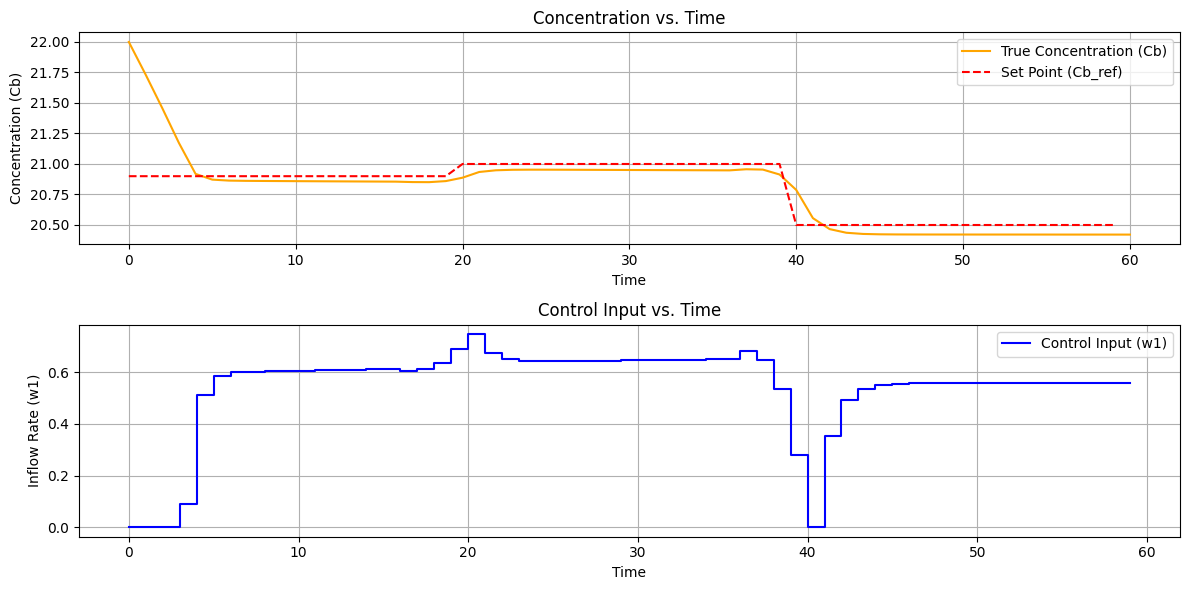

In [31]:
plot_results(Cb_res, Cb_ref, w1_res)

#### Evaluation of optimal `w1` using the real system dynamics

In [32]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# --- Real System Dynamics --- #
def system_of_odes(t, y, w2):
    h, Cb = y
    w1 = w1_func(t)  # Get w1 at time t using interpolation
    dh_dt = w1 + w2 - 0.2 * np.sqrt(h)
    dCb_dt = ((Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2)
    return [dh_dt, dCb_dt]

# Make negative w1_res zero
t_points = np.arange(0, L, dt)  
w1_func = interp1d(t_points, w1_res, kind='linear', fill_value="extrapolate")

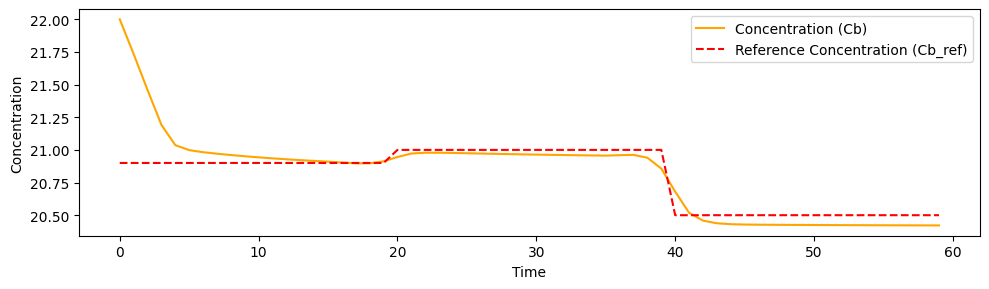

In [33]:
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
times = np.arange(0, L, dt)
sol_t = [0]
sol_h = [h0]
sol_Cb = [Cb0]

for i in range(len(times)-1):
    sol = solve_ivp(system_of_odes, [times[i], times[i+1]], y0, args=(w2,), method='RK45')  
    y0 = sol.y[:, -1]  # Update initial condition
    sol_t.append(times[i+1])
    sol_h.append(y0[0])
    sol_Cb.append(y0[1])
    
sol_t = np.array(sol_t)
sol_h = np.array(sol_h)
sol_Cb = np.array(sol_Cb)

# --- Plotting --- #
plt.figure(figsize=(10, 3))
plt.plot(sol_t, sol_Cb, label='Concentration (Cb)', color='orange')
plt.plot(sol_t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.tight_layout()
plt.show()

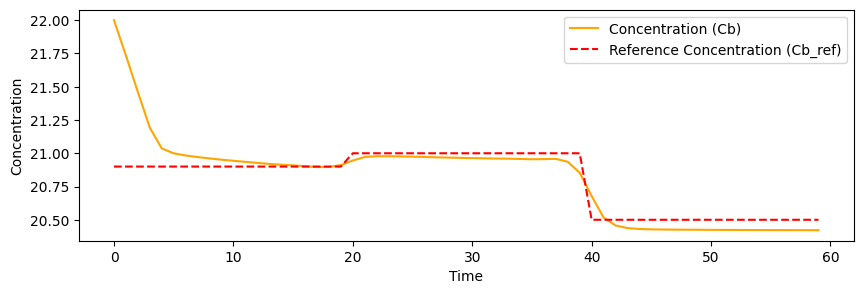

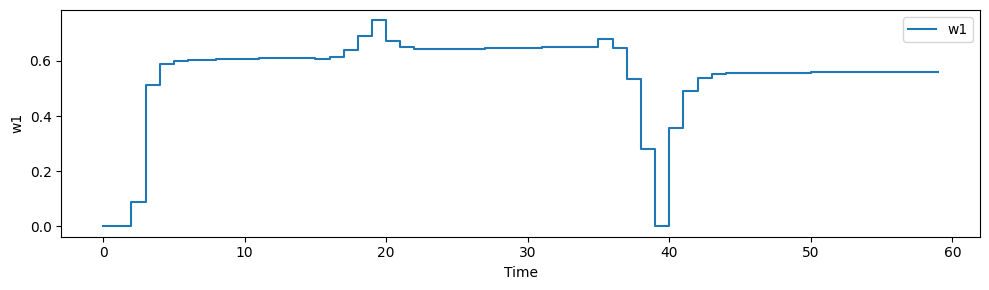

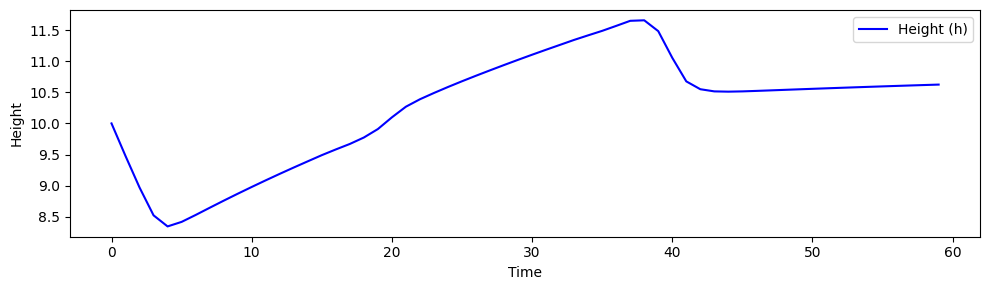

In [34]:
# Time span for the solution
t_span = (0, L)  # From t=0 to t=L
y0 = [h0, Cb0]  # Initial
sol = solve_ivp(system_of_odes, t_span, y0, args=(w2,), 
                method='Radau', t_eval=np.arange(0, L, dt))

# Extract the solution
t = sol.t
h = sol.y[0]
Cb = sol.y[1]

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Concentration (Cb)', color='orange')
plt.plot(t, Cb_ref, label='Reference Concentration (Cb_ref)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

# Plot the input w1
plt.figure(figsize=(10, 3))
plt.step(t, w1_func(t), label='w1')
plt.xlabel('Time')
plt.ylabel('w1')    
plt.legend()

plt.tight_layout()
plt.show()

# Plot h 
plt.figure(figsize=(10, 3))
plt.plot(t, h, label='Height (h)', color='blue')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
results_df = pd.DataFrame()
results_df['MPC'] = Cb_res[:-1]
results_df['Real'] = Cb
results_df['Diff'] = np.abs(results_df['MPC'] - results_df['Real'])
results_df

,MPC,Real,Diff
0,22.000000,22.000000,0.000000e+00
1,21.734571,21.734571,7.262464e-08
2,21.459090,21.459514,4.241680e-04
3,21.172980,21.192154,1.917334e-02
4,20.918706,21.036561,1.178552e-01
5,20.871917,20.999388,1.274718e-01
6,20.863813,20.983213,1.193998e-01
7,20.861810,20.971444,1.096333e-01
8,20.860889,20.961130,1.002407e-01
9,20.860093,20.951912,9.181886e-02


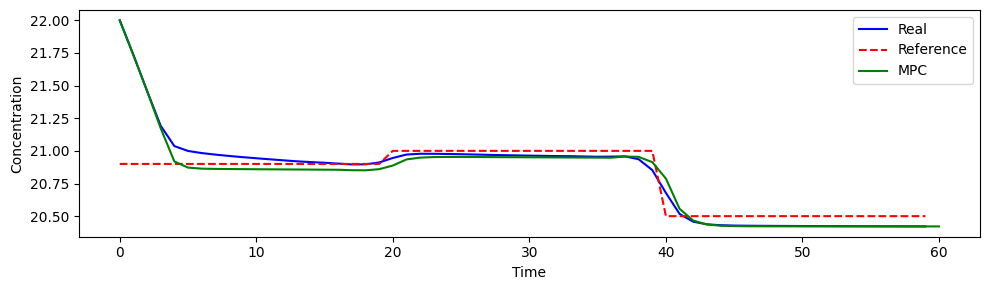

In [36]:
# Plot results
plt.figure(figsize=(10, 3))
plt.plot(t, Cb, label='Real', color='blue')
plt.plot(t, Cb_ref, label='Reference', color='red', linestyle='--')
plt.plot(Cb_res, label='MPC', color='green', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.tight_layout()
plt.show()